In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as patches

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist
pynrc.setup_logging('WARNING', verbose=False)

from astropy.io import fits

# Observations Definitions

Functions to create at optimize a series of observation objects stored as a dictionary.

In [3]:
def make_key(filter, pupil=None, mask=None):
    """Create identification key (string) based on filter, pupil, and mask"""
    mask_key = 'none' if mask is None else mask
    pupil_key = 'none' if pupil is None else pupil
    key = '{}_{}_{}'.format(filter,mask_key,pupil_key)
    return key

In [4]:
def model_info(source, filt, dist):
    
    base_dir  = '/Volumes/NIRData/Andras_models_v2/'
    model_dir = base_dir + source + '/'
    
    # Match filters with model
    filt_switch = {'F182M':'F210M', 'F210M':'F210M', 'F250M':'F250M',
                   'F300M':'F300M', 'F335M':'F335M', 'F444W':'F444W'}
    filt_model = filt_switch.get(filt, filt)
    fname = source + '_' + filt_model +'final.fits'

    bp = nrc_utils.read_filter(filt_model)
    w0 = bp.avgwave() / 1e4

    # Model pixels are 4x oversampled
    detscale = (nrc_utils.channel_select(bp))[0]
    model_scale = detscale
    
    # File name, arcsec/pix, dist (pc), wavelength (um), flux units
    args_model = (model_dir+fname, model_scale, dist, w0, 'Jy/pixel')

    return args_model

In [5]:
def obs_wfe(wfe_drift, filt_list, sp_sci, dist, sp_ref=None, disk_mod=True, fov_pix=None, verbose=False):
    """
    For a given WFE drift and series of filters, create a list of 
    NIRCam observations. This function will calculate PSFs out to 320 pixels. 
    For the case of SW+MASK335R, we also assume that the subarray size matches 
    that of a simultaneous LW observation (320x320).
    """
    if sp_ref is None:
        sp_ref = sp_sci
    
    fov_pix_orig = fov_pix
    
    obs_dict = {}
    for filt, mask, pupil in filt_list:
        if verbose: print(filt, mask, pupil)

        # Disk Model
        if disk_mod:
            # Convert to photons/sec in specified filter
            args_disk = model_info(sp_sci.name, filt, dist)
            hdu_disk = model_to_hdulist(args_disk, sp_sci, filt, pupil=pupil, mask=mask)
        else:
            hdu_disk = None
        
        # Create identification keys
        key = make_key(filt, mask=mask, pupil=pupil)

        # Set the PSF size and oversampling amount
        fov_pix = 320 if fov_pix is None else fov_pix
        oversample = 2

        # Initialize and store the observation
        # A reference obseration is stored inside each parent obs_coronagraphy class.
        obs_dict[key] = pynrc.obs_coronagraphy(sp_sci, sp_ref, dist, wind_mode='FULL',
                                               disk_hdu=hdu_disk, wfe_drift=wfe_drift,
                                               filter=filt, mask=mask, pupil=pupil, 
                                               oversample=oversample, fov_pix=fov_pix,
                                               verbose=verbose)
        fov_pix = fov_pix_orig

    return obs_dict

In [6]:
def obs_optimize(obs_dict, sp_opt=None, well_levels=None, tacq_max=1800, **kwargs):
    """
    Perform ramp optimization on each science and reference observation
    in a list of filter observations. Updates the detector MULTIACCUM
    settings for each observation in the dictionary.
    
    snr_goal = 5
    snr_frac = 0.02
    tacq_max = 1400
    tacq_frac = 0.01
    nint_min = 15
    ng_max = 10
    patterns = None
    """

    # A very faint bg object on which to maximize S/N
    # If sp_opt is not set, then default to a 20th magnitude flat source
    if sp_opt is None:
        bp_k = S.ObsBandpass('k')
        sp_opt = pynrc.stellar_spectrum('flat', 20, 'vegamag', bp_k)

    
    # Some observations may saturate, so define a list of  maximum well level
    # values that we will incrementally check until a ramp setting is found
    # that meets the contraints.
    if well_levels is None:
        well_levels = [0.8, 1.5, 3.0, 5.0, 10.0, 20.0, 100.0, 150.0, 300.0, 500.0]
   
    filt_keys = obs_dict.keys()
    filt_keys.sort()
    print(['Pattern', 'NGRP', 'NINT', 't_int', 't_exp', 't_acq', 'SNR', 'Well', 'eff'])
    for j, key in enumerate(filt_keys):
        print('')
        print(key)

        obs = obs_dict[key]
        sp_sci, sp_ref = (obs.sp_sci, obs.sp_ref)
        
        # SW filter piggy-back on two LW filters, so 2 x tacq
        is_SW = obs.bandpass.avgwave()/1e4 < 2.5

        sci = obs
        ref = sci.nrc_ref

        # Ramp optimization for both science and reference targets
        for obs2, sp in zip([sci, ref], [sp_sci, sp_ref]):
            i = nrow = 0
            while nrow==0:
                well_max = well_levels[i]
                tbl = obs2.ramp_optimize(sp_opt, sp, well_frac_max=well_max, tacq_max=tacq_max, **kwargs)
                nrow = len(tbl)
                i+=1
                
            # Grab the highest ranked MULTIACCUM settings and update the detector readout
            v1, v2, v3 = tbl['Pattern', 'NGRP', 'NINT'][0]
            
            vals = tbl[0].as_void()
            strout = ', '.join(map(str, vals))
            print(strout)

            # SW filter piggy-back on two LW filters, so 2 x tacq
            # Only for Debris Disk program
            #is_SW = obs.bandpass.avgwave()/1e4 < 2.5
            #if is_SW: v3 *= 2
            
            # Coronagraphic observations have two roll positions, so cut NINT by 2
            if obs.mask is not None: v3 = int(v3/2) 
            obs2.update_detectors(read_mode=v1, ngroup=v2, nint=v3)
        

## Plotting contrasts and planet magnitudes

Functions to plot simulated images and contrast curves

In [7]:
def plot_contrasts(curves, wfe_list, ax=None, colors=None, return_ax=False):
    """Plot a series of contrast curves for corresponding WFE drifts."""
    if ax is None:
        fig, ax = plt.subplots()
    if colors is None:
        lin_vals = np.linspace(0.2,0.7,len(wfe_list))
        colors = plt.cm.Blues_r(lin_vals)[::-1]
    for j, wfe_drift in enumerate(wfe_list):
        rr, contrast, mag_sens = curves[j]
        label="WFE Drift = {} nm".format(wfe_list[j])
        ax.plot(rr, mag_sens, label=label, color=colors[j], zorder=1, lw=2)
        
    if return_ax: return ax


def planet_mags(obs, age=10, entropy=13, mass_list=[10,5,2,1], av_vals=[0,25]):
    """Determine series of exoplanet magnitudes for given observation."""

    pmag = {}
    for i,m in enumerate(mass_list):
        flux_list = []
        for j,av in enumerate(av_vals):
            sp = obs.planet_spec(mass=m, age=age, Av=av, entropy=entropy, atmo='hy3s')
            sp_obs = S.Observation(sp, obs.bandpass, binset=obs.bandpass.wave)
            flux = sp_obs.effstim('vegamag')
            flux_list.append(flux)
        pmag[m] = tuple(flux_list)
        
    return pmag

        
def plot_planet_patches(ax, obs, age=10, entropy=13, mass_list=[10,5,2,1], av_vals=[0,25]):
    """Plot exoplanet magnitudes in region corresponding to extinction values."""
    
    xlim = ax.get_xlim()
    cols = plt.cm.tab10(np.linspace(0,1,10))
    
    dist = obs.distance
    
    pmag = planet_mags(obs, age, entropy, mass_list, av_vals)
    for i,m in enumerate(mass_list):
        pm_min, pm_max = pmag[m]
        label = 'Mass = {} '.format(m) + '$M_{\mathrm{Jup}}$'
        rect = patches.Rectangle((xlim[0], pm_min), xlim[1], pm_max-pm_min, alpha=0.2,
                                 color=cols[i], label=label, zorder=2)
        ax.add_patch(rect)
        ax.plot(xlim, [pm_min]*2, color=cols[i], lw=1, alpha=0.3)
        ax.plot(xlim, [pm_max]*2, color=cols[i], lw=1, alpha=0.3)
        

    entropy_switch = {13:'Hot', 8:'Cold'}
    entropy_string = entropy_switch.get(entropy, lambda: "Warm")
    ent_str = entropy_string + ' Start'
    #ent_str = '{} Start'.format(entropy_string)

    av_str = '$A_V = [{:.0f},{:.0f}]$'.format(av_vals[0],av_vals[1])
    age_str = 'Age = {:.0f} Myr; '.format(age)
    dist_str = 'Dist = {:.1f} pc; '.format(dist) if dist is not None else ''
    #dist_str=""

    ax.set_title('{} -- {} ({}{}{})'.format(obs.filter,ent_str,age_str,dist_str,av_str))


In [8]:
from copy import deepcopy

def plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, save_fig=False):
    nfilt = len(filt_keys)
    ext_name = ['Model', 'Sim Image (linear scale)', 'Sim Image ($r^2$ scale)']
    nim = len(ext_name)

    fig, axes = plt.subplots(nim, nfilt, figsize=(14,7.5))
    axes = axes.transpose()
    for j, k in enumerate(filt_keys):
        obs = obs_dict[k]
        hdu_mod = obs.disk_hdulist
        hdu_sim = hdu_dict[k]

        # Make r^2 scaled version of data
        hdu_sim_r2 = deepcopy(hdu_sim)
        data  = hdu_sim_r2[0].data
        header = hdu_sim_r2[0].header
        rho = nrc_utils.dist_image(data, pixscale=header['PIXELSCL'])
        data *= rho**2

        # Max value for model
        data_mod   = hdu_mod[0].data
        header_mod = hdu_mod[0].header
        rho_mod    = nrc_utils.dist_image(data_mod, pixscale=header_mod['PIXELSCL'])
        data_mod_r2 = data_mod*rho_mod**2
        vmax  = np.max(data_mod)
        vmax2 = np.max(data_mod_r2)
        
        # Scale value for data
        mask_good = data_mod>(0.1*vmax)
        scl1 = np.median(hdu_sim[0].data[mask_good] / data_mod[mask_good])
        
        # Scale value for r^2 version
        mask_good = data_mod_r2>(0.1*vmax2)
        scl2 = np.median(hdu_sim_r2[0].data[mask_good] / data_mod_r2[mask_good])

        vmax_vals = [vmax,vmax*scl1,vmax2*scl2]
        hdus = [hdu_mod, hdu_sim, hdu_sim_r2]
        for i, ax in enumerate(axes[j]):
            hdulist = hdus[i]
            data = hdulist[0].data
            header = hdulist[0].header

            pixscale = header['PIXELSCL']
            rho = nrc_utils.dist_image(data, pixscale=pixscale)

            rad = data.shape[0] * pixscale / 2
            extent = [-rad, rad, -rad, rad]

            ax.imshow(data, vmin=0, vmax=0.9*vmax_vals[i], extent=extent)

            ax.set_aspect('equal')
            if j > 0: ax.set_yticklabels([])
            if i < nim-1: ax.set_xticklabels([])
            if i==nim-1: ax.set_xlabel('Arcsec')
            if j==0: ax.set_ylabel(ext_name[i])

            if i==0: ax.set_title(obs.filter)

            if fov>2*rad:
                xlim = [-rad,rad]
                ylim = [-rad,rad]
            else:
                xlim = [-fov/2,fov/2]
                ylim = [-fov/2,fov/2]
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

            ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
            ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

            ax.tick_params(axis='both', color='white', which='both')
            for k in ax.spines.keys():
                ax.spines[k].set_color('white')

            
    texp = obs_dict[filt_keys[-1]].multiaccum_times['t_exp']
    texp = round(2*texp/100)*100
    exp_text = "t_exp = {:.0f} sec".format(texp)
    wfe_text = "WFE Drift = {} nm".format(wfe_drift)
    fig.suptitle('{} ({}; {})'.format(name_sci, exp_text, wfe_text), fontsize=16);
    fig.tight_layout()

    fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.9, bottom=0.07 , left=0.05, right=0.97)
    
    fname = "{}_images.pdf".format(name_sci.replace(" ", ""))
    if save_fig: 
        fig.savefig(outdir+fname)

## Functions to init, optimize, and plot

In [9]:
# Generate initial observations for each filter(no WFE drift)
def do_init(disk_mod=True, fov_pix=1024, verbose=True):
    wfe_drift = 0
    obs_dict = obs_wfe(wfe_drift, args_list, sp_sci, dist_sci, sp_ref=sp_ref, 
                       disk_mod=disk_mod, fov_pix=fov_pix, verbose=verbose)
    return obs_dict

In [10]:
# Optimize observations
def do_opt(tacq_max, **kwargs):
    sp_opt = pynrc.stellar_spectrum('flat', 20, 'vegamag', bp_k)
    obs_optimize(obs_dict, sp_opt=sp_opt, tacq_max=tacq_max, **kwargs)

In [11]:
# For each filter setting, generate a series of contrast curves at different WFE values
def do_contrast(wfe_list, filt_keys, nsig=5, roll_angle=None):
    contrast_all = {}
    for i, key in enumerate(filt_keys):
        print(key)
        obs = obs_dict[key]

        filt, mask, pupil = args_list[i]
        if roll_angle is None:
            roll_angle = 0 if mask is None else 10

        # Stores tuple of (Radial Distances, Contrast, and Sensitivity) for each WFE drift
        curves = []
        for wfe_drift in wfe_list:
            obs.wfe_drift = wfe_drift
            result = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig)
            curves.append(result)

        contrast_all[key] = curves
    return contrast_all

In [12]:
def do_plot_contrast(obs, curves, wfe_list, nsig, age, xlim=[0,10], ylim=[24,8], save_fig=False):

    fig, axes = plt.subplots(1,2, figsize=(13,4.5))
    entropy_vals = [13,8]

    for j, ax in enumerate(axes.flatten()):
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        plot_contrasts(curves, wfe_list, ax=ax)
        plot_planet_patches(ax, obs, age=age, entropy=entropy_vals[j])

    for ax in axes.flatten():
        ax.set_xlabel('Distance (arcsec)')
        ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.legend(ncol=2)

    fig.tight_layout()
    
    t_exp = obs.multiaccum_times['t_exp']
    t_exp = round(2*t_exp/100)*100
    fig.suptitle('{} (t_exp = {:.0f} sec)'.format(name_sci, t_exp), fontsize=16);
    #fig.subplots_adjust(top=0.85)
    fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.1 , left=0.05, right=0.97)

    fname = "{}_contrast.pdf".format(name_sci.replace(" ", ""))
    if save_fig: 
        fig.savefig(outdir+fname)

In [13]:
def do_gen_hdus(obs_dict, wfe_drift, **kwargs):
    
    hdulist_dict = {}
    for key in filt_keys:
        obs = obs_dict[key]
        obs.wfe_drift = wfe_drift
        hdulist = obs.gen_roll_image(PA1=0, PA2=10, **kwargs)
        
        hdulist_dict[key] = hdulist
        
    return hdulist_dict

# Eps Eri

In [14]:
# List of filters
args_list = [('F356W', 'MASK430R', 'CIRCLYOT'),
             ('F444W', 'MASK430R', 'CIRCLYOT')]

filt_keys = []
for filt,mask,pupil in args_list:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

In [15]:
# K-Band Filter
bp_k = S.ObsBandpass('k')

In [16]:
outdir  = '/Volumes/NIRData/Andras_obs_v3/'

In [17]:
name_sci, dist_sci, fov, age, spt_sci, kmag_sci = ('Eps Eri', 3.2, 20, 500, 'K2V', 1.67)
name_ref, spt_ref, kmag_ref = ('HR1050', 'K2III', 3.245)

# Science target and reference star spectra
sp_sci = pynrc.stellar_spectrum(spt_sci, kmag_sci, 'vegamag', bp_k, catname='ck04models')
sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k, catname='ck04models')
sp_sci.name = name_sci
sp_ref.name = name_ref

In [18]:
obs_dict = do_init(verbose=True, disk_mod=False)

F356W MASK430R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F444W MASK430R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.


In [19]:
for k in filt_keys:
    obs = obs_dict[k]
    obs.wfe_drift = 5

In [20]:
obs1 = obs_dict[filt_keys[0]]
obs2 = obs_dict[filt_keys[1]]

In [21]:
obs1.update_detectors(read_mode='RAPID', ngroup=9, nint=5)
obs1.nrc_ref.update_detectors(read_mode='RAPID', ngroup=9, nint=5)

obs2.update_detectors(read_mode='BRIGHT2', ngroup=7, nint=6)
obs2.nrc_ref.update_detectors(read_mode='BRIGHT2', ngroup=7, nint=6)

In [22]:
# Full frame slope images
xpix = obs1.det_info['xpix']
ypix = obs1.det_info['ypix']

In [27]:
wfe_list = [0,5]
nsig = 5
curves_dict = do_contrast(wfe_list, filt_keys, nsig=nsig)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


In [28]:
curves1 = curves_dict[filt_keys[0]]
curves2 = curves_dict[filt_keys[1]]

In [29]:
# Determine number of saturated pixels where fixing is unreliable
rmax1 = []
rmax2 = []
nsat1 = []
nsat2 = []
for sp in [sp_sci, sp_ref]:
    #######################################
    # F356W Observation
    #######################################
    sat_level = obs1.saturation_levels(sp)
    print('1st Frame Saturation for {} + {}: {:.2f}'.format(sp.name,obs1.filter,sat_level.max()))
    sat_mask = sat_level > 0.8
    rho = nrc_utils.dist_image(sat_level)
    
    # How many saturated values can we easily fix?
    sat_level[sat_mask] = np.nan
    sat_level = nrc_utils.fix_nans_with_med(sat_level, niter_max=2)
    
    # Set any NaNs to 1.0
    nan_mask = np.isnan(sat_level)
    sat_level[nan_mask] = 1
    sat_mask = sat_level > 0.8
    
    # Get final info about saturation levels
    nsat = np.size(rho[sat_mask])    
    rval = rho[sat_mask].max() if nsat>0 else 0
    nsat1.append(nsat)
    rmax1.append(rval*obs1.pix_scale)

    #######################################
    # F444W Observation
    #######################################
    sat_level = obs2.saturation_levels(sp)
    print('1st Frame Saturation for {} + {}: {:.2f}'.format(sp.name,obs2.filter,sat_level.max()))
    sat_mask = sat_level > 0.8

    # How many saturated values can we easily fix?
    sat_level[sat_mask] = np.nan
    sat_level = nrc_utils.fix_nans_with_med(sat_level, niter_max=2)
    
    # Set any NaNs to 1.0
    nan_mask = np.isnan(sat_level)
    sat_level[nan_mask] = 1
    sat_mask = sat_level > 0.8

    # Get final info about saturation levels
    nsat = np.size(rho[sat_mask])    
    rval = rho[sat_mask].max() if nsat>0 else 0
    nsat2.append(nsat)
    rmax2.append(rval*obs2.pix_scale)
        

rmax1 = np.max(rmax1)
rmax2 = np.max(rmax2)
nsat1 = np.max(nsat1)
nsat2 = np.max(nsat2)

1st Frame Saturation for Eps Eri + F356W: 0.83
1st Frame Saturation for Eps Eri + F444W: 0.39
1st Frame Saturation for HR1050 + F356W: 0.20
1st Frame Saturation for HR1050 + F444W: 0.09


In [30]:
print(nsat1, nsat2)
print(rmax1, rmax2)

0 0
0.0 0.0


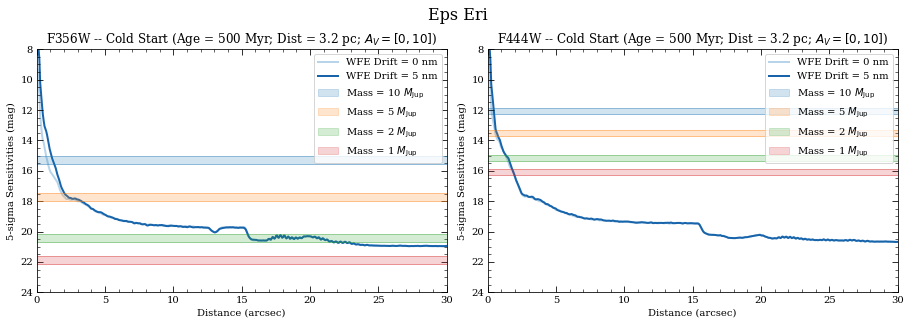

In [31]:
xlim=[0,30]
ylim=[24,8]

fig, axes = plt.subplots(1,2, figsize=(13,4.5))
ax1, ax2 = axes
entropy_vals = [13,8]

for j, ax in enumerate(axes):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

plot_contrasts(curves1, wfe_list, ax=ax1)
plot_contrasts(curves2, wfe_list, ax=ax2)
plot_planet_patches(ax1, obs1, age=age, entropy=8, av_vals=[0,10])
plot_planet_patches(ax2, obs2, age=age, entropy=8, av_vals=[0,10])

label = 'Saturation'
if rmax1>0:
    rect1 = patches.Rectangle((0,ylim[0]), rmax1, ylim[1]-ylim[0], alpha=0.5,
                              color='grey', label=label, zorder=2)
    ax1.add_patch(rect1)
if rmax2>0:
    rect2 = patches.Rectangle((0,ylim[0]), rmax2, ylim[1]-ylim[0], alpha=0.5,
                              color='grey', label=label, zorder=2)
    ax2.add_patch(rect2)

for ax in axes.flatten():
    ax.set_xlabel('Distance (arcsec)')
    ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))
    ax.legend(ncol=1)
    
    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

fig.tight_layout()

#t_exp = obs.multiaccum_times['t_exp']
#t_exp = round(2*t_exp/100)*100
#fig.suptitle('{} (t_exp = {:.0f} sec)'.format(name_sci, t_exp), fontsize=16);
fig.suptitle(name_sci, fontsize=16);
#fig.subplots_adjust(top=0.85)
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.1 , left=0.05, right=0.97)


## Full observation simulations

In [23]:
# Select F444W with two rolls at PA of 250 and 260
obs = obs2

roll_angle = 10
PA1 = 250
PA2 = PA1 + roll_angle

In [24]:
# Detector ID
det = obs.Detectors[0]
detid = det.detid

In [25]:
# Get mask center from SIAF aperture file
from jwxml import siaf
inst = siaf.SIAF('NIRCam')
apname = 'NRC'
ap = inst['NRCA5_MASK430R']
mask_cen = ap.center('Det')

In [26]:
# Add random planet
rtheta = (3, 45.0) # 3" at PA=45
# Output images will be in coordinates with V3 up and V2 to the left
obs.add_planet(mass=1, age=age, entropy=8, rtheta=rtheta, runits='arcsec')

In [27]:
# Coronagraphic Transmission mask
# +V3 is up, and +V2 is to the left
# Pixel (0,0) is bottom right
cmask = nrc_utils.build_mask('A', pixscale=obs.pix_scale) + 999
cmask = nrc_utils.pad_or_cut_to_size(cmask, (ypix,xpix))

# Place cmask in detector coords
cmask = nrc_utils.V2V3_to_det(cmask, detid)

# Shift cmask to appropriate location
# ie., move MASK430R from center
xc, yc = (xpix/2, ypix/2)
xnew, ynew = (int(mask_cen[0]), int(mask_cen[1])) # In detector coords
delx = xnew - xc
dely = ynew - yc

cmask = nrc_utils.fshift(cmask, delx, dely) + 1
cmask[cmask>10] = cmask[cmask>10] - 1000

cmask[1500:,0:260]=0
cmask[1500:,1900:]=0
cmask[1820:,:] = 0

In [28]:
# Make zodiacal background image
im_zodi = cmask * obs.bg_zodi()

In [29]:
# Planet Images
im_pl1 = obs.gen_planets_image(PA_offset=PA1)
im_pl2 = obs.gen_planets_image(PA_offset=PA2)

# Convert to Detector Coordinates (flip along x-axis)
im_pl1 = nrc_utils.V2V3_to_det(im_pl1, detid)
im_pl2 = nrc_utils.V2V3_to_det(im_pl2, detid)

# Shift to MASK430R spot
im_pl1 = nrc_utils.fshift(im_pl1, delx, dely, pad=True)
im_pl2 = nrc_utils.fshift(im_pl2, delx, dely, pad=True)

# Mask out opaque areas from disk
imask = cmask<1e-2
im_pl1[imask] = im_pl1[imask]*cmask[imask]
im_pl2[imask] = im_pl2[imask]*cmask[imask]

In [30]:
# Create stellar images
im_star = obs.gen_psf(sp_sci)
im_ref  = obs.nrc_ref.gen_psf(sp_ref)

im_star = nrc_utils.pad_or_cut_to_size(im_star, (ypix,xpix))
im_ref  = nrc_utils.pad_or_cut_to_size(im_ref, (ypix,xpix))

# Convert to Detector Coordinates (flip along x-axis)
im_star = nrc_utils.V2V3_to_det(im_star, detid)
im_ref  = nrc_utils.V2V3_to_det(im_ref, detid)

# Shift to MASK430R spot
im_star = nrc_utils.fshift(im_star, delx, dely, pad=True)
im_ref  = nrc_utils.fshift(im_ref, delx, dely, pad=True)

In [31]:
sci_slope1 = im_star + im_pl1 + im_zodi
sci_slope2 = im_star + im_pl2 + im_zodi

ref_slope  = im_ref + im_zodi

# Make sure there are no negative numbers
#for slp in [sci_slope1, sci_slope2, ref_slope]:
#    slp[slp<0] = 0

In [32]:
# Superbias for data reduction
caldir  = pynrc.conf.PYNRC_PATH + 'sca_images/'
fbias = caldir + 'SUPER_BIAS_485.FITS'
hdl = fits.open(fbias)
bias = hdl[0].data

In [33]:
def average_slopes(ramps, bias):
    """
    For a series of ramps, calculate the slope images then average together.
    Would it be better to average integrations into one ramp, then find slope???
    
    
    """

    slopes_fin = []
    for i in range(len(ramps)):
        #print(i)
        hdulist = ramps[i]
        data = hdulist[1].data
        header = hdulist[0].header
        ref_obj = pynrc.ref_pixels.NRC_refs(data, header, DMS=True)
        ref_obj.calc_avg_amps()
        ref_obj.correct_amp_refs()

        # Subtract superbias
        data_corr = ref_obj.data
        for im in data_corr:
            im -= bias

        # Create time array
        ng = data_corr.shape[0]
        tvals = (np.arange(ng)+1) * obs.multiaccum_times['t_group']

        # Flatten image space to 1D
        data_corr = data_corr.reshape([ng,-1])

        # Make saturation mask
        sat_val = 0.8*data_corr.max()
        sat_mask = data_corr > sat_val

        # Create slope images
        # Cycle through frames using only unsaturated pixels 
        im_slope = np.zeros_like(data_corr[0]) - 10
        for i in np.arange(1,ng)[::-1]:
            ind = (im_slope==-10) & (~sat_mask[i])
            if np.any(ind): # Check if any pixels are still True
                im_slope[ind] = pynrc.fast_poly.jl_poly_fit(tvals, data_corr[:,ind])[1]
            #print(im_slope[ind].shape)

        # Special case of only first frame unsaturated
        ind = (im_slope==-10) & (~sat_mask[0])
        im_slope[ind] = data_corr[:,ind] / tvals[0]
        #print(im_slope[ind].shape)

        # If saturated on first frame, set to NaN
        ind = sat_mask[0]
        im_slope[ind] = np.nan
        #print(im_slope[ind].shape)

        data_corr = data_corr.reshape([ng,ypix,xpix])
        im_slope = im_slope.reshape([ypix,xpix])
        slopes_fin.append(im_slope)

    slopes_fin = np.array(slopes_fin)
    slope_final = np.nanmedian(slopes_fin, axis=0)
    
    # Fix NaNs
    slope_final = nrc_utils.fix_nans_with_med(slope_final)

    return slope_final

In [34]:
ramps = obs.gen_exposures(im_slope=sci_slope1, targ_name=name_sci)
slope_final1 = average_slopes(ramps, bias)

In [35]:
ramps = obs.gen_exposures(im_slope=sci_slope2, targ_name=name_sci)
slope_final2 = average_slopes(ramps, bias)

In [36]:
ramps = obs.nrc_ref.gen_exposures(im_slope=ref_slope, targ_name=name_ref)
slope_ref = average_slopes(ramps, bias)

In [37]:
med1 = np.median(slope_final1)
med2 = np.median(slope_final2)
med_ref = np.median(slope_ref)

print(med1, med2, med_ref)

0.18127057565 0.174012376091 0.181151225458


In [38]:
x1, x2 = (xnew-50, xnew+50)
y1, y2 = (ynew-50, ynew+50)

ref_sub = slope_ref[y1:y2, x1:x2] - med_ref
im1_sub = slope_final1[y1:y2, x1:x2] - med1
im2_sub = slope_final2[y1:y2, x1:x2] - med2

# Scale factor for Roll 1
scale1 = nrc_utils.scale_ref_image(im1_sub, ref_sub)

# Scale factor for Roll 2
scale2 = nrc_utils.scale_ref_image(im2_sub, ref_sub)

In [39]:
print(scale1, scale2)

4.19846924841 4.22462300151


In [94]:
# In detector coords
diff1 = (slope_final1-med1) - (slope_ref-med_ref)*scale1
diff2 = (slope_final2-med2) - (slope_ref-med_ref)*scale2

In [71]:
mask_good = cmask>1e-2
diff1 = nrc_utils.optimal_difference(slope_final1, slope_ref, scale1, mask_good=mask_good,
                                     center=(xnew,ynew))#, std_func=pynrc.robust.medabsdev)
diff2 = nrc_utils.optimal_difference(slope_final2, slope_ref, scale2, mask_good=mask_good,
                                     center=(xnew,ynew))#, std_func=pynrc.robust.medabsdev)

In [339]:
for i in range(nbins):
    if std2[i] < std1[i]:
        diff1_good[igroups[i]] = diff2_good[igroups[i]]

diff1[mask_good] = diff1_good

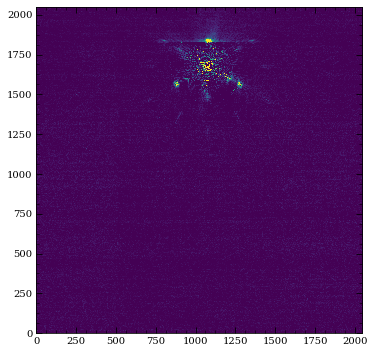

In [73]:
plt.imshow(diff1, vmin=0, vmax=1)

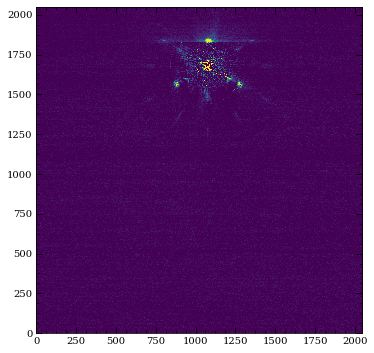

In [340]:
plt.imshow(diff1, vmin=0, vmax=1)

In [ ]:
np.isna

In [234]:
S_d1.indices

array([3348338, 3349975, 3349976, ...,   10240,   10241,       0], dtype=int32)

In [255]:
%time test = S_d1.toarray()

CPU times: user 266 ms, sys: 619 ms, total: 885 ms
Wall time: 884 ms


In [258]:
len(groups)

399

In [253]:
groups[10]

array([ 15.62470961,  14.00362091,  15.96754728, ...,  15.08132736,
        10.72341456,  17.17733658])

In [202]:
test = binned_statistic(rho, diff1, np.std, nbins)

In [189]:
(rvals-0.5).astype(int)

array([   0,    1,    2, ..., 1988, 1989, 1990])

In [161]:
from scipy.sparse import csr_matrix
N = len(diff1)
r0 = rho.min()
r1 = rho.max()
nbins = rvals.size

digitized = (float(nbins-1) / (r1-r0) * (rho-r0)).astype(int)


In [193]:
digitized.shape

(4194304,)

In [195]:
nbins

1991

In [190]:
test = csr_matrix((diff1, [rvals, np.arange(N)]), shape=(nbins, N))

ValueError: row, column, and data array must all be the same length

In [168]:
test2 = np.array([np.std(group) for group in np.split(test.data, test.indptr[1:-1])])

In [183]:
test.indptr.shape

(1992,)

In [171]:
def binned_statistic(x, values, func, nbins=None, range=None):
    '''The usage is approximately the same as the scipy one''' 
    from scipy.sparse import csr_matrix
    N = len(values)
    
    if range is None:
        r0 = x.min()
        r1 = x.max()
    else:
        r0, r1 = range

    digitized = (np.float(nbins-1) / (r1-r0) * (x-r0)).astype(int)
    S = csr_matrix((values, [digitized, np.arange(N)]), shape=(nbins, N))

    return np.array([func(group) for group in np.split(S.data, S.indptr[1:-1])])

In [116]:
rho = rho.flatten()

In [120]:
urho = np.unique(rho)

In [122]:
rvals

array([  5.00000000e-01,   1.50000000e+00,   2.50000000e+00, ...,
         1.98850000e+03,   1.98950000e+03,   1.99050000e+03])

In [123]:
bins = np.arange(rho.min(), rho.max() + 1, 1)

In [134]:
bins.shape

(1992,)

In [117]:
np.histogram(rho, bins, )

CPU times: user 559 ms, sys: 4.78 ms, total: 564 ms
Wall time: 562 ms


In [118]:
test

array([3427382, 3425334, 3427383, ...,    2048,       1,       0])

In [87]:
from scipy.ndimage.interpolation import rotate
def rotateImage(img, angle, pivot, trim=True):
    padX = [img.shape[1] - pivot[0], pivot[0]]
    padY = [img.shape[0] - pivot[1], pivot[1]]
    imgP = np.pad(img, [padY, padX], 'constant')
    imgR = rotate(imgP, angle, reshape=False, cval=np.nan)
    if trim: imgR = imgR[padY[0] : -padY[1], padX[0] : -padX[1]]
    
    return imgR

In [95]:
# Convert back to V2/V3 coordinates
diff1_v23 = nrc_utils.det_to_V2V3(diff1, detid)
diff2_v23 = nrc_utils.det_to_V2V3(diff2, detid)


xnew_flip = xpix - xnew

diff2_rot = rotateImage(diff2_v23, roll_angle, (xnew_flip,ynew))
im_final = (diff1_v23 + diff2_rot) / 2
nan_mask = np.isnan(im_final)
im_final[nan_mask] = diff1_v23[nan_mask]

In [96]:
im_final_shift = nrc_utils.fshift(im_final, xpix/2-xnew_flip, ypix/2-ynew, pad=True)
im_final_rot = rotate(im_final_shift, PA1, reshape=False)
im_final_rot_sub = nrc_utils.pad_or_cut_to_size(im_final_rot, (800,800))

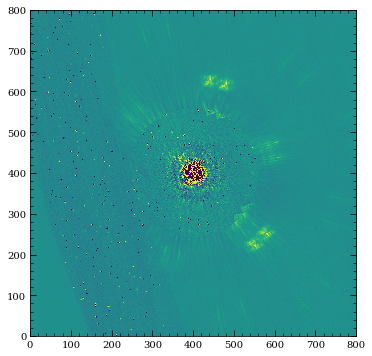

In [93]:
plt.imshow(im_final_rot_sub, vmin=-1, vmax=1)

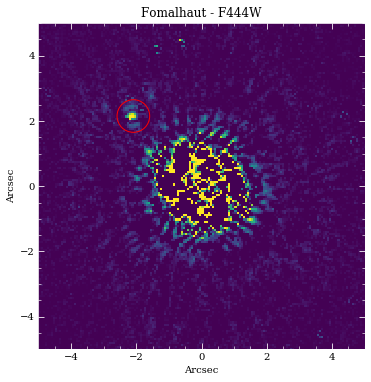

In [92]:
fig, ax = plt.subplots(1,1)

ys, xs = im_final_rot_sub.shape
extent = np.array([-xs/2,xs/2,-ys/2,ys/2])*obs.pix_scale

ax.imshow(im_final_rot_sub, vmin=-3, vmax=5, extent=extent)
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
ax.set_xlabel('Arcsec')
ax.set_ylabel('Arcsec')
ax.set_title('Fomalhaut - {}'.format(obs.filter))

ax.tick_params(axis='both', color='white', which='both')
for k in ax.spines.keys():
    ax.spines[k].set_color('white')

# Location of planet
loc = (np.array(obs.planets[0]['xyoff_pix'])+0.5) * obs.pix_scale
circle = matplotlib.patches.Circle(loc, 0.5, lw=1, edgecolor='red', facecolor='none')
ax.add_artist(circle);



In [104]:
test = np.array([[1,2,3,np.nan],[2,3,4,np.nan]])
#test2 = np.array([2,3,4,5])
#np.nanmean([])
np.nanmean(test,axis=0)

array([ 1.5,  2.5,  3.5,  nan])